In [89]:
import pandas as pd

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, root_mean_squared_error

import pickle

In [91]:
df = pd.read_parquet('../data/green_tripdata_2021-01.parquet')

In [92]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime

In [93]:
# df = df[df.trip_type == 2]

In [94]:
df.duration = df.duration.apply(lambda td:td.total_seconds()/60)

In [95]:
df.duration.describe(percentiles=[0.95,0.96,0.98,0.99])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
95%         44.000000
96%         47.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

In [96]:
df = df[((df.duration > 1) & (df.duration <= 60))]

In [97]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

Learn one hot coding from ML Zoomcamp playlist/repository

In [98]:
df[categorical] = df[categorical].astype(str)

In [99]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [100]:
dv = DictVectorizer()
train_x = dv.fit_transform(train_dicts)

In [101]:
train_x

<73833x507 sparse matrix of type '<class 'numpy.float64'>'
	with 221499 stored elements in Compressed Sparse Row format>

In [102]:
target = 'duration'
train_y = df[target].values

In [103]:
train_y

array([ 3.93333333,  8.75      ,  5.96666667, ..., 11.        ,
       27.        , 10.        ])

In [104]:
lr = LinearRegression()
lr.fit(train_x, train_y)

LinearRegression()

In [105]:
pred_y = lr.predict(train_x)

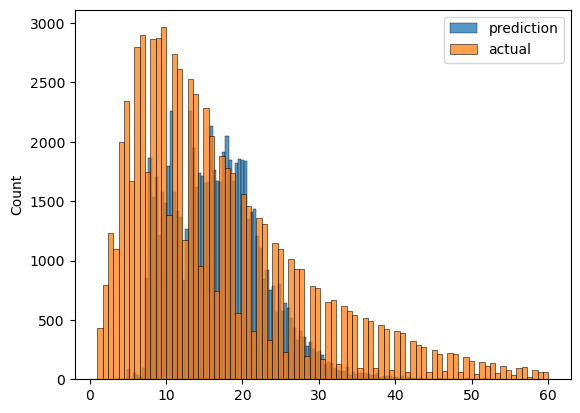

In [106]:
sns.histplot(pred_y, label='prediction')
sns.histplot(train_y, label='actual')

plt.legend()

In [107]:
root_mean_squared_error(train_y, pred_y)

9.821212542376422

In [108]:
def read_data(filename):
    df = pd.read_parquet(filename)
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td:td.total_seconds()/60)
    df = df[((df.duration > 1) & (df.duration <= 60))]
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df

In [109]:
train_df = read_data('../data/green_tripdata_2021-01.parquet')
val_df = read_data('../data/green_tripdata_2021-02.parquet')

In [110]:
len(train_df), len(val_df)

(73833, 61889)

In [111]:
train_df['PU_DO'] = train_df['PULocationID'] + '_' + train_df['DOLocationID']
val_df['PU_DO'] = val_df['PULocationID'] + '_' + val_df['DOLocationID']

In [112]:
categorical = ['PU_DO'] #['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [113]:
dv = DictVectorizer()

train_dicts = train_df[categorical+numerical].to_dict(orient='records')
train_x = dv.fit_transform(train_dicts)

val_dicts = val_df[categorical+numerical].to_dict(orient='records')
val_x = dv.transform(val_dicts)

In [114]:
target = 'duration'
train_y = train_df[target].values
val_y = val_df[target].values

In [115]:
lr = LinearRegression()
lr.fit(train_x, train_y)

pred_y = lr.predict(val_x)
root_mean_squared_error(val_y, pred_y)

7.75693226347022

In [116]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)